In [1]:
import os
import time

import tensorflow as tf
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor

%matplotlib inline

print(f"TensorFlow (v{tf.version.VERSION})")
try:
    physical_device = tf.config.list_physical_devices('GPU')[0]
    print(f"GPU device: {physical_device.name}")
    tf.config.experimental.set_memory_growth(physical_device, True)
except:
    print("Invalid device or cannot modify virtual devices once initialized. Device name {}".format(
        physical_device.name
    ))
    pass

TensorFlow (v2.3.1)
GPU device: /physical_device:GPU:0


In [2]:
def load_image(filename):
    raw = tf.io.read_file(filename)
    image = tf.image.decode_png(raw, channels=3)
    return image

In [3]:
def random_augment(image, factor=0.3):

    def random_perspective(image):
        theta = tf.random.uniform([1], minval=-15, maxval=16, dtype=tf.dtypes.int32).numpy()[0]
        tx = tf.random.uniform((1, ), minval=-30, maxval=31, dtype=tf.dtypes.int32).numpy()[0]
        ty = tf.random.uniform((1, ), minval=-30, maxval=31, dtype=tf.dtypes.int32).numpy()[0]
        shear = tf.random.uniform([1], minval=-15, maxval=16, dtype=tf.dtypes.int32).numpy()[0]
        zx = tf.random.uniform((1, ), minval=0.7, maxval=1.0).numpy()[0]
        zy = tf.random.uniform((1, ), minval=0.7, maxval=1.0).numpy()[0]
        perspective = tf.keras.preprocessing.image.apply_affine_transform(
            image, theta, tx, ty, shear, zx, zx,
            row_axis=0, col_axis=1, channel_axis=2
        )
        return perspective  
    
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_brightness(image, 0.08).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_contrast(image, 0.7, 1.0).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_saturation(image, 0.7, 1.0).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_flip_left_right(image).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_flip_up_down(image).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_hue(image, 0.1).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.image.random_jpeg_quality(image, 5, 100).numpy()
    if tf.random.normal([1]) > 0.5:
        image = tf.keras.preprocessing.image.random_rotation(image, 45, row_axis=0, col_axis=1, channel_axis=2)
    if tf.random.normal([1]) > 0.5:
        image = random_perspective(image)
    return image

In [4]:
def get_labeled_image(filepath):
    image = load_image(filepath)
    label = tf.strings.split(filepath, sep=' ')[0]
    label = tf.strings.split(label, sep=os.sep)[-1]
    label = tf.strings.to_number(label, out_type=tf.int32) - 1
    return image, label

In [5]:
def get_files(root):
    PATHS = list()

    def parse_dir(root):
        if os.path.isfile(root):
            PATHS.append(root)
        elif os.path.isdir(root):
            for dirname in os.listdir(root):
                parse_dir(os.path.join(root, dirname))

    parse_dir(root)
    return PATHS

In [6]:
IMAGE_PATHS = get_files('icons')
print('\n'.join(IMAGE_PATHS))

icons\1 — Test.png
icons\10 — Cap.png
icons\2 — Medal.png
icons\3 — PC.png
icons\4 — Search.png
icons\5 — Projector.png
icons\6 — Idea.png
icons\7 — Telescope.png
icons\8 — Briefcase.png
icons\9 — Trofy.png


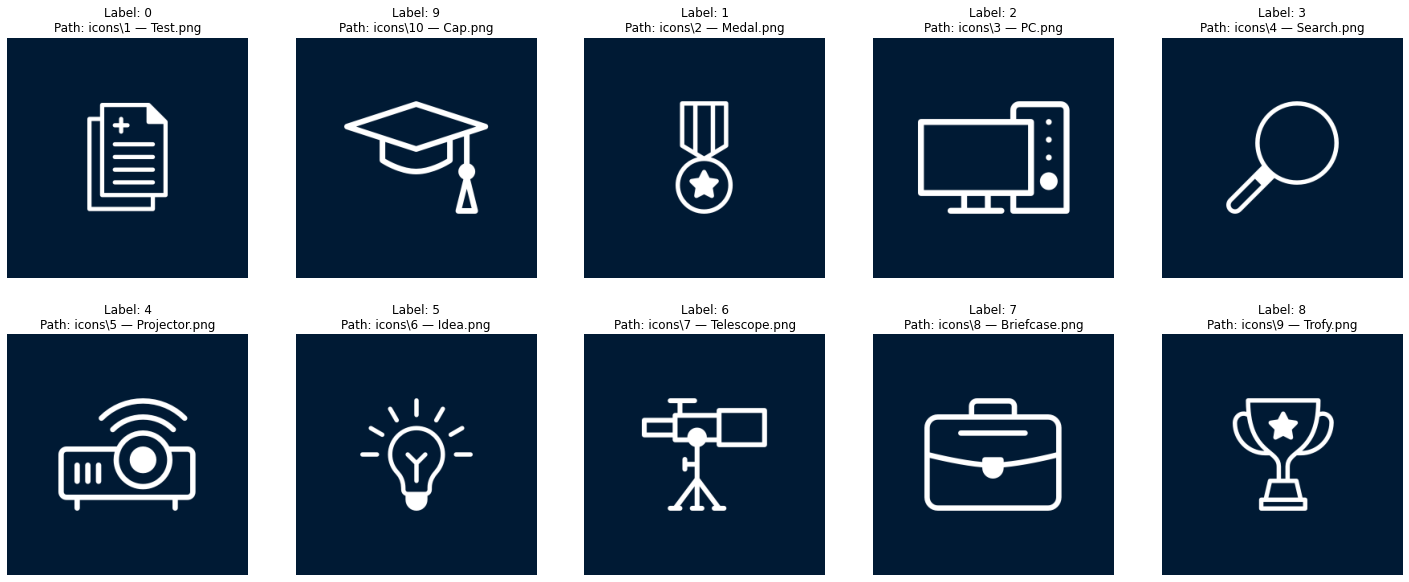

In [7]:
plt.figure(figsize=(25, 10))
for i, path in enumerate(IMAGE_PATHS):
    image, label = get_labeled_image(path)

    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"Label: {label}\nPath: {path}")
    plt.axis('off')

plt.show()

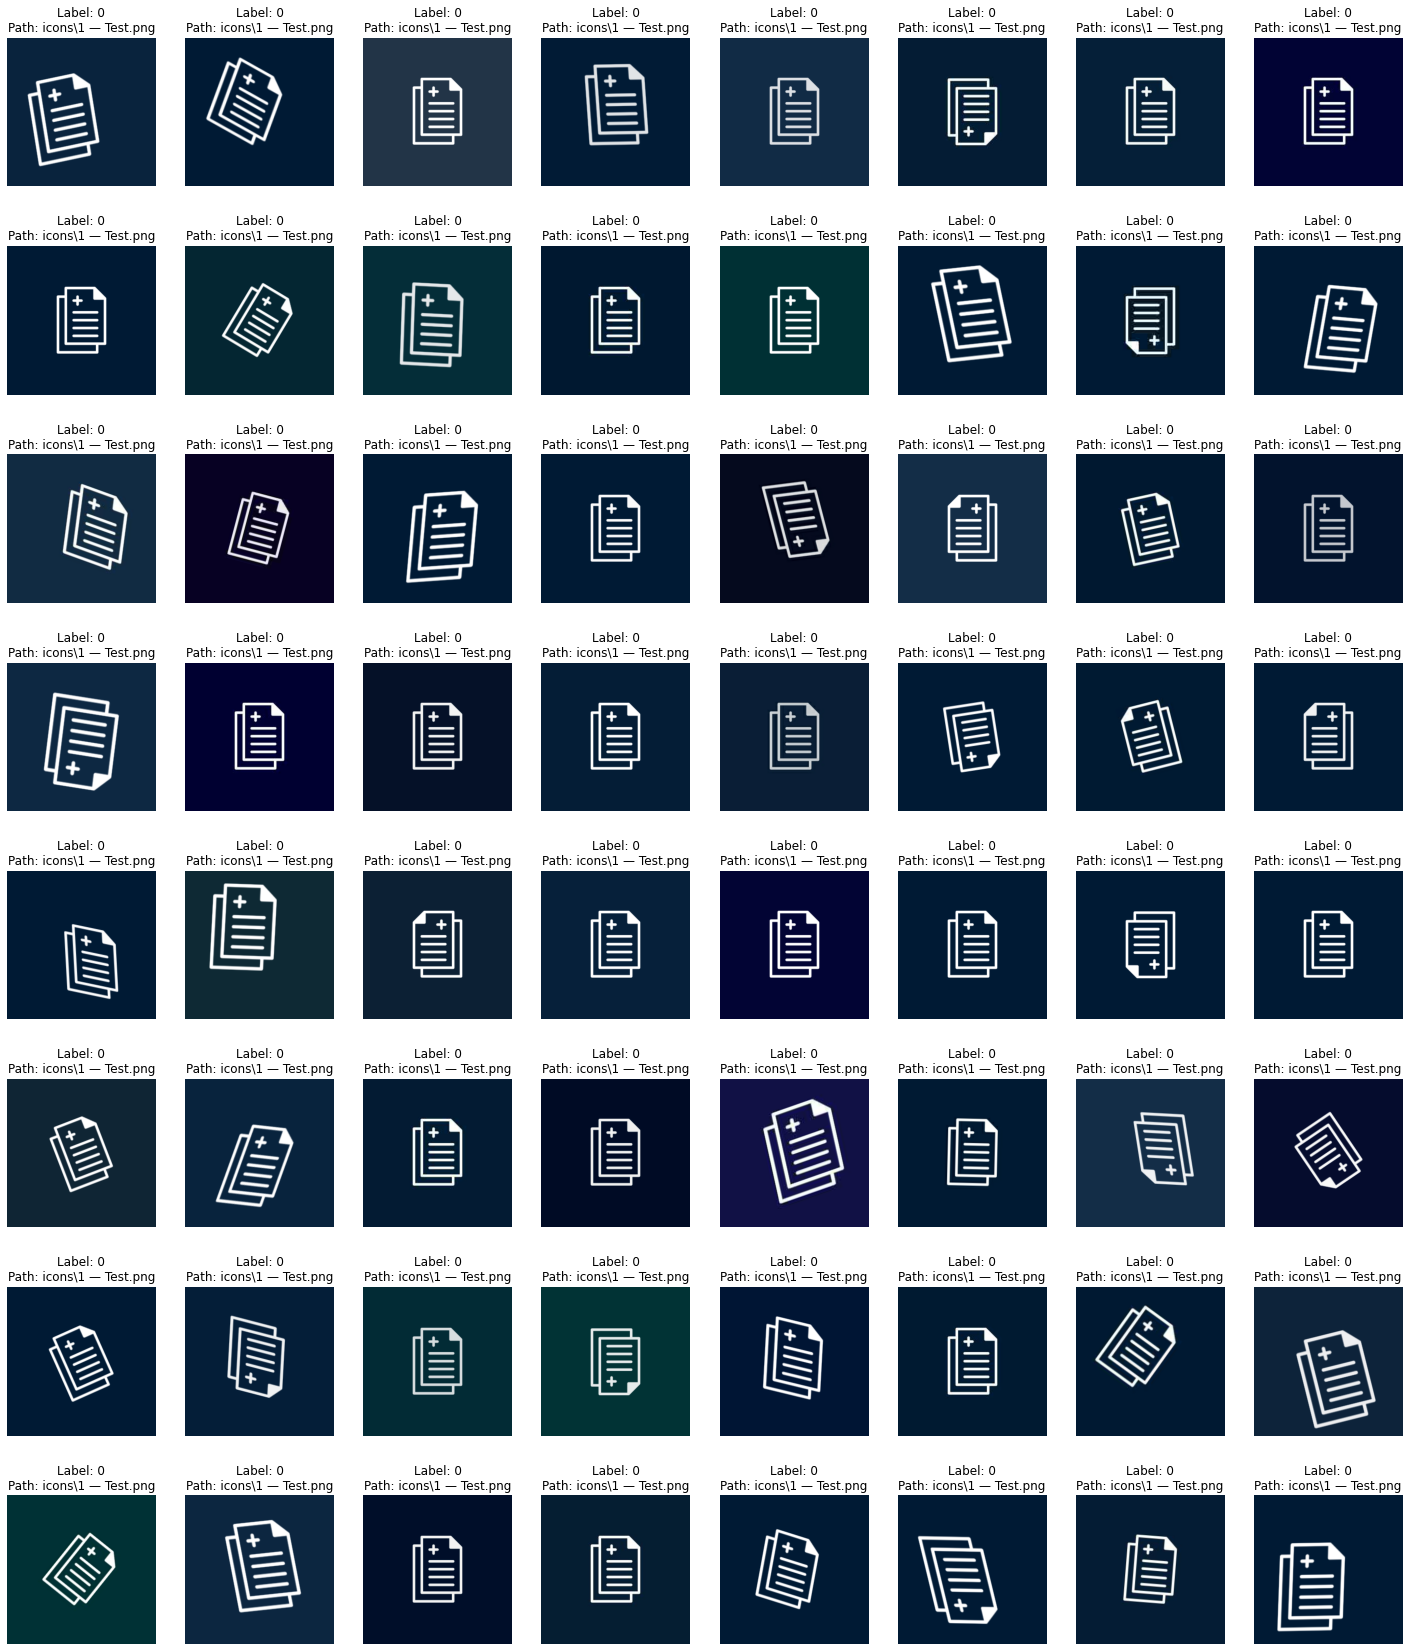

In [8]:
plt.figure(figsize=(25, 30))
for i, path in enumerate([IMAGE_PATHS[0]] * 64):
    image, label = get_labeled_image(path)
    # image = tf.image.convert_image_dtype()
    image = random_augment(image.numpy())

    plt.subplot(8, 8, i+1)
    plt.imshow(image)
    plt.title(f"Label: {label}\nPath: {path}")
    plt.axis('off')

plt.show()

In [38]:
def get_data(paths):

    images = list()
    labels = list()
    data = list()
    
    with ThreadPoolExecutor() as pool:
        data = list(pool.map(get_labeled_image, paths))

    for x, y in data:
        images.append(x)
        labels.append(y)

    return images, labels
    

In [154]:
def augment_batch(images):
    images = images.numpy()
    with ThreadPoolExecutor() as pool:
        data = list(pool.map(random_augment, images))
    return tf.cast(data, tf.dtypes.float32)

In [155]:
images, labels = get_data(IMAGE_PATHS)

In [156]:
images = tf.cast(images, tf.dtypes.float32)/255.
labels = tf.cast(labels, tf.dtypes.int32)
images.shape, labels.shape

(TensorShape([10, 300, 300, 3]), TensorShape([10]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


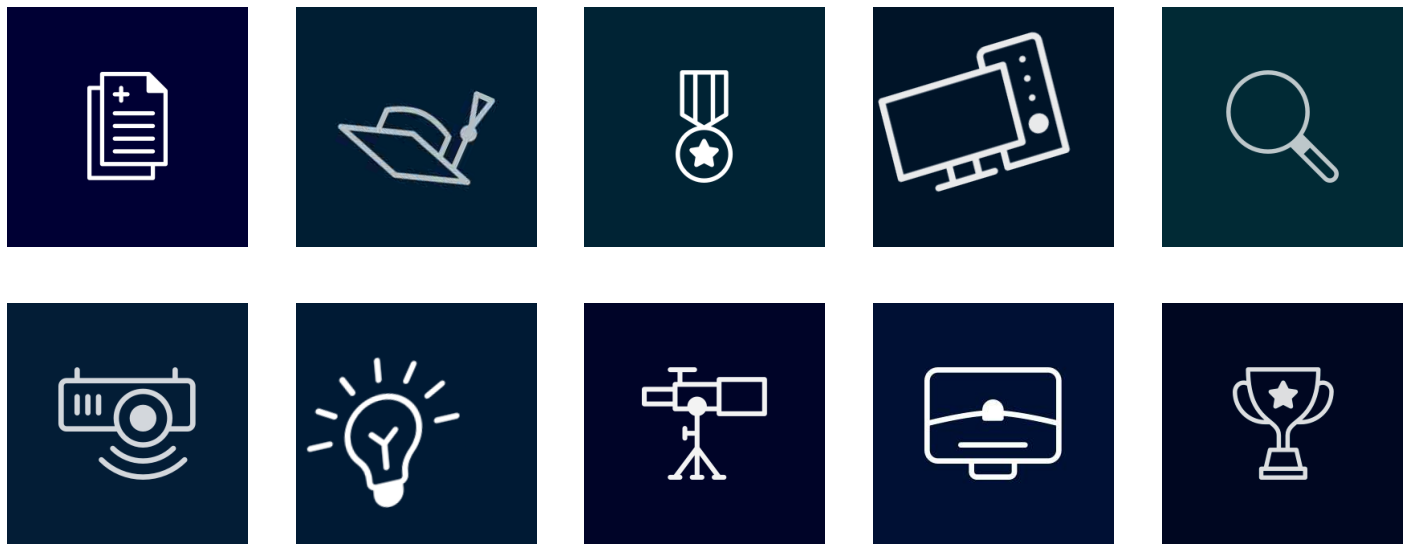

In [157]:
a = augment_batch(images)
plt.figure(figsize=(25, 10))
for i, image in enumerate(a):
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [169]:
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
train_dataset = dataset.repeat(20).shuffle(200).batch(20)
test_dataset = dataset.repeat(20).shuffle(200).batch(20)
train_dataset, test_dataset

(<BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int32)>)

In [173]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((300, 300, 3)),
    tf.keras.layers.Conv2D(filters=8, kernel_size=1),
    tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=(1, 1), groups=8, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=1),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), groups=16, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=1),
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(3, 3), groups=32, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(filters=16, kernel_size=1),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2, 2), groups=16, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=(2, 2), groups=16, padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10),
], name='ArtWayClass')

model.summary()

Model: "ArtWayClass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 300, 300, 8)       32        
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 300, 300, 8)       80        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 150, 150, 8)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 150, 150, 16)      144       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 75, 75, 16)        

In [13]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch == 0 or (epoch+1) % 10 == 0:
            tf.print('Epoch {:4d} - loss: {:.4f} - acc: {:.4f}, val_loss: {:.4f}, val_acc - {:.4f}'.format(
                epoch+1, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']))

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [22]:
model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
    # callbacks=[CustomCallback()],
    # verbose=0,
)

Epoch 1/10
6/6 [==============================] - 2s 348ms/step - loss: 0.0989 - accuracy: 0.9743 - val_loss: 0.3052 - val_accuracy: 0.8933
Epoch 2/10
6/6 [==============================] - 1s 244ms/step - loss: 0.0634 - accuracy: 0.9800 - val_loss: 0.6612 - val_accuracy: 0.8067
Epoch 3/10
6/6 [==============================] - 1s 243ms/step - loss: 0.0451 - accuracy: 0.9943 - val_loss: 0.3639 - val_accuracy: 0.8933
Epoch 4/10
6/6 [==============================] - 1s 244ms/step - loss: 0.0368 - accuracy: 0.9971 - val_loss: 0.3234 - val_accuracy: 0.8933
Epoch 5/10
6/6 [==============================] - 1s 245ms/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.3430 - val_accuracy: 0.8933
Epoch 6/10
6/6 [==============================] - 1s 245ms/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 0.4758 - val_accuracy: 0.8600
Epoch 7/10
6/6 [==============================] - 1s 244ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.4792 - val_accuracy: 0.8533
Epoch 8/10
6/6 [====

In [174]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [175]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        preds = model(x, training=True)
        loss_val = loss(y_true=y, y_pred=preds)

    grads = tape.gradient(loss_val, model.trainable_weights)
    optimizer.apply_gradients(zip(grads ,model.trainable_weights))
    train_acc_metric.update_state(y_true=y, y_pred=preds)
    return loss_val

In [176]:
@tf.function
def test_step(x, y):
    preds = model(x, training=True)
    loss_val = loss(y_true=y, y_pred=preds)
    test_acc_metric.update_state(y_true=y, y_pred=preds)
    return loss_val

In [179]:
def train(model, train_dataset, test_dataset, epochs):
    for epoch in range(epochs):
        train_acc_metric.reset_states()
        test_acc_metric.reset_states()
        start_time = time.time()
        for images, labels in train_dataset:
            images = augment_batch(images)
            train_loss_val = train_step(images, labels)
        train_acc_val = train_acc_metric.result()

        for images, labels in test_dataset:
            images = augment_batch(images)
            test_loss_val = test_step(images, labels)
        test_acc_val = test_acc_metric.result()
        
        print("Epoch {:4d} - {:.0f}s loss: {:.3f} - acc: {:.3f} - val_loss: {:.3f} - val_acc: {:.3f}".format(
            epoch+1, time.time()-start_time, train_loss_val, train_acc_val, test_loss_val, test_acc_val
        ))

In [181]:
train(model, train_dataset, test_dataset, epochs=15)

Epoch    1 - 42s loss: 0.888 - acc: 0.690 - val_loss: 0.922 - val_acc: 0.735
Epoch    2 - 42s loss: 0.895 - acc: 0.705 - val_loss: 0.760 - val_acc: 0.720
Epoch    3 - 42s loss: 0.801 - acc: 0.725 - val_loss: 0.662 - val_acc: 0.690
Epoch    4 - 42s loss: 0.757 - acc: 0.715 - val_loss: 1.054 - val_acc: 0.700
Epoch    5 - 42s loss: 1.036 - acc: 0.730 - val_loss: 1.035 - val_acc: 0.730
Epoch    6 - 42s loss: 1.029 - acc: 0.735 - val_loss: 0.901 - val_acc: 0.725
Epoch    7 - 42s loss: 0.777 - acc: 0.690 - val_loss: 1.014 - val_acc: 0.740
Epoch    8 - 42s loss: 0.957 - acc: 0.705 - val_loss: 0.913 - val_acc: 0.785
Epoch    9 - 43s loss: 0.765 - acc: 0.765 - val_loss: 1.135 - val_acc: 0.730
Epoch   10 - 42s loss: 0.778 - acc: 0.705 - val_loss: 1.131 - val_acc: 0.785
Epoch   11 - 42s loss: 0.570 - acc: 0.785 - val_loss: 1.010 - val_acc: 0.830
Epoch   12 - 42s loss: 0.708 - acc: 0.740 - val_loss: 0.916 - val_acc: 0.840
Epoch   13 - 42s loss: 0.914 - acc: 0.730 - val_loss: 0.909 - val_acc: 0.705

In [184]:
train(model, train_dataset, test_dataset, epochs=20)

Epoch    1 - 42s loss: 0.307 - acc: 0.860 - val_loss: 0.153 - val_acc: 0.890
Epoch    2 - 41s loss: 0.427 - acc: 0.880 - val_loss: 0.460 - val_acc: 0.875
Epoch    3 - 42s loss: 0.516 - acc: 0.905 - val_loss: 0.436 - val_acc: 0.885
Epoch    4 - 42s loss: 0.622 - acc: 0.910 - val_loss: 0.348 - val_acc: 0.870
Epoch    5 - 41s loss: 0.314 - acc: 0.905 - val_loss: 0.636 - val_acc: 0.885
Epoch    6 - 42s loss: 0.715 - acc: 0.890 - val_loss: 0.499 - val_acc: 0.855
Epoch    7 - 42s loss: 0.320 - acc: 0.890 - val_loss: 0.522 - val_acc: 0.855
Epoch    8 - 42s loss: 0.252 - acc: 0.890 - val_loss: 0.633 - val_acc: 0.910
Epoch    9 - 42s loss: 0.418 - acc: 0.885 - val_loss: 0.376 - val_acc: 0.885
Epoch   10 - 42s loss: 0.068 - acc: 0.895 - val_loss: 0.313 - val_acc: 0.870
Epoch   11 - 42s loss: 0.408 - acc: 0.910 - val_loss: 0.498 - val_acc: 0.895
Epoch   12 - 42s loss: 0.261 - acc: 0.910 - val_loss: 0.589 - val_acc: 0.880
Epoch   13 - 42s loss: 0.222 - acc: 0.860 - val_loss: 0.392 - val_acc: 0.915

In [185]:
model.save("models/ArtWayClass-1.0.h5")